In [28]:
import numpy as np
import copy
import matplotlib.pyplot as plt

Parameters and function setting

In [29]:
def solution(x, y):
    return np.sin(3.0 * np.pi * x ** 2 * y) + (y - 1.0) ** 3

In [30]:
def f(x, y):
    return 18 * np.pi * (np.pi * x ** 2 * np.sin(3 * np.pi * x ** 2 * y) * (x ** 2 + 6 * y ** 2) - y * np.cos(3 * np.pi * x ** 2 * y)) - 12 * (y - 1)

In [31]:
def a(x, y):
    return 3

def b(x, y):
    return 2

Mapping function

In [32]:
def idx(i, j, N):
    return (j-1) * (N - 1) + (i-1)

SLAE compilation

In [33]:
def SLAE_compilation(N: int):
    h = 1.0 / N
    size = (N - 1) ** 2 
    
    A = np.zeros((size, size))
    rhs = np.zeros(size)
    
    coeff_x = a(0, 0) / h**2
    coeff_y = b(0, 0) / h**2
    
    for j in range(1, N):  # y
        for i in range(1, N):  # x
            k = idx(i, j, N=N)
            x, y = i*h, j*h
            
            # diagonal
            A[k, k] = 2*(a(0, 0)+b(0, 0))/h**2
            rhs[k] = f(x, y) 
            
            # neighbours
            # east (i+1,j)
            if i < N-1:
                A[k, idx(i+1,j, N)] = -coeff_x
            else:  # border x=1
                rhs[k] += coeff_x * solution(1.0, y)
            
            # west (i-1,j)
            if i > 1:
                A[k, idx(i-1,j, N)] = -coeff_x
            else:  # border x=0
                rhs[k] += coeff_x * solution(0.0, y)
            
            # nord (i,j+1)
            if j < N-1:
                A[k, idx(i,j+1, N)] = -coeff_y
            else:  # border y=1
                rhs[k] += coeff_y * solution(x, 1.0)
            
            # sud (i,j-1)
            if j > 1:
                A[k, idx(i,j-1, N)] = -coeff_y
            else:  # border y=0
                rhs[k] += coeff_y * solution(x, 0.0)
    
    return A, rhs

Exact solution vector

In [34]:
def exact_vector(N):
    h = 1.0 / N
    u_ex = np.zeros((N-1)**2)
    k = 0
    for j in range(1, N):
        for i in range(1, N):
            x, y = i*h, j*h
            u_ex[k] = solution(x, y)
            k += 1
    return u_ex


Conjugate gradient method

In [45]:
def conjugate_gradient(A: np.ndarray, b_vec: np.ndarray, eps: float, max_it: int) -> tuple[np.ndarray, int]:
    it = 0

    x_cur = np.zeros_like(b_vec)
    r_cur = b_vec - A @ x_cur
    p_cur = copy.deepcopy(r_cur)

    while np.linalg.norm(r_cur) > eps and it < max_it:
        r_prev = copy.deepcopy(r_cur)
        p_prev = copy.deepcopy(p_cur)
        alpha_prev = np.dot(r_prev, r_prev) / np.dot(A @ p_prev, p_prev)
        x_prev = copy.deepcopy(x_cur)
        x_cur = x_prev + alpha_prev * p_prev
        r_cur = r_prev - alpha_prev * A @ p_prev
        beta_prev = np.dot(r_cur, r_cur) / np.dot(r_prev, r_prev)
        p_cur = r_cur + beta_prev * p_prev
        # print(f"norm(r_cur) = {np.linalg.norm(r_cur)}\n")
        it += 1
    return x_cur, it

Richardson method

In [36]:
def Richardson(A: np.ndarray, b_vec: np.ndarray, eps: float, max_it: int) -> np.ndarray:
    it = 0

    eigvals = np.linalg.eigvals(A)
    lambda_max = max(np.abs(eigvals))
    
    tau = 1.0 / lambda_max 

    x = np.zeros_like(b_vec)
    r = A @ x - b_vec
    while np.linalg.norm(r) > eps and it < max_it:
        x = x - tau * r
        r = A @ x - b_vec
        # print(f"norm(r) = {np.linalg.norm(r)}\n")
        it += 1

    return x, it

Numerical experiments

In [43]:
number_of_nodes = np.arange(4, 30, 5)

1) Error on iterations number

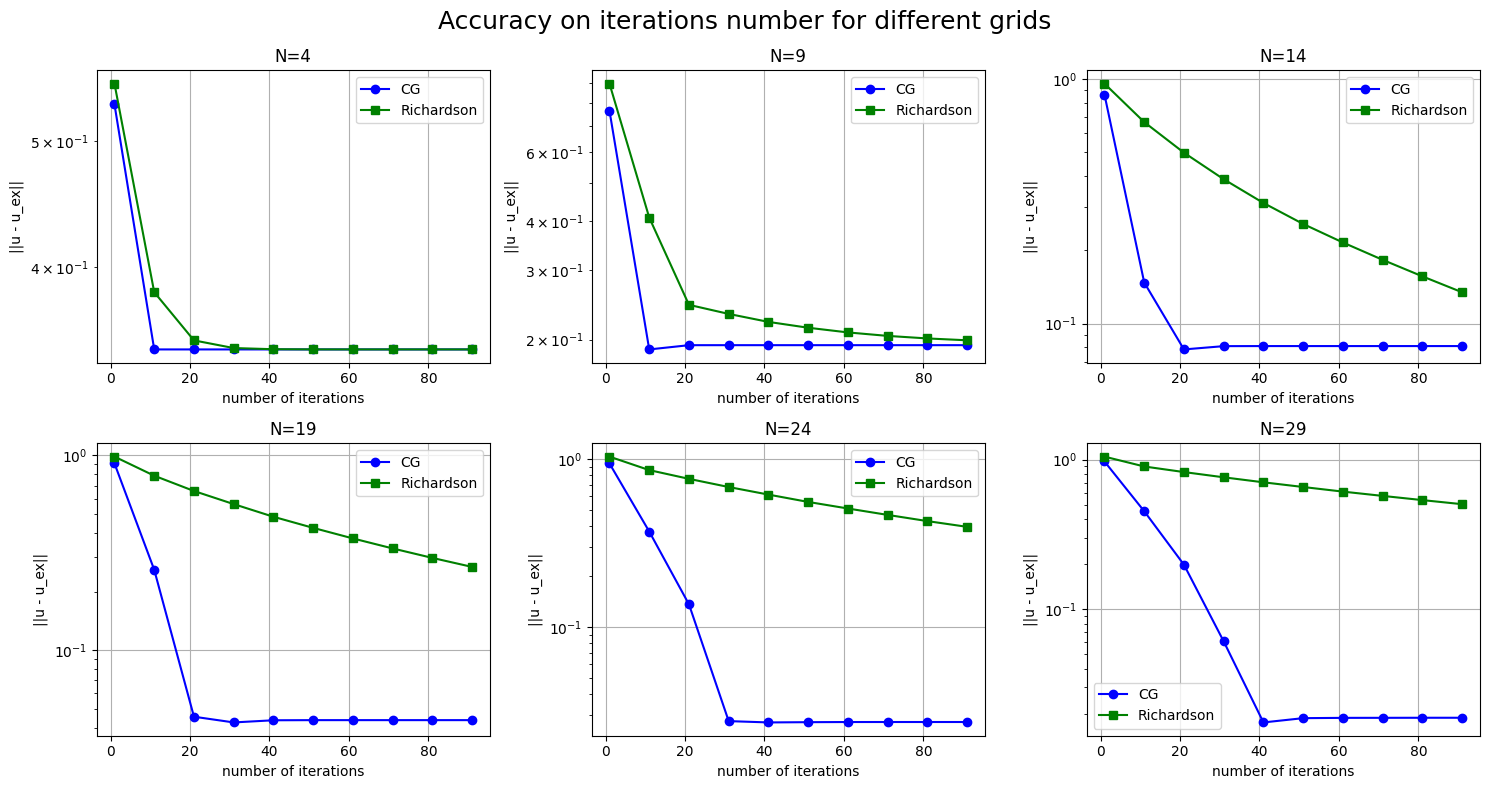

In [44]:
max_iterations_numbers = np.arange(1, 101, 10)

eps = 1e-20

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.ravel() 

for index, N in enumerate(number_of_nodes):
    A, b_vec = SLAE_compilation(N)
    errors_cg = []
    errors_rich = []
    numbers_of_iterations = []

    u_ex = exact_vector(N)

    for max_it in max_iterations_numbers:
        u_cg, it_cg = conjugate_gradient(A=A, b_vec=b_vec, eps=eps, max_it=max_it)
        u_rich, it_rich = Richardson(A=A, b_vec=b_vec, eps=eps, max_it=max_it)
        errors_cg.append(np.max(np.abs(u_cg - u_ex)))
        errors_rich.append(np.max(np.abs(u_rich - u_ex)))

    ax = axes[index]
    ax.semilogy(max_iterations_numbers, errors_cg, color = 'blue', marker="o", label="CG")
    ax.semilogy(max_iterations_numbers, errors_rich, color = 'green', marker="s", label="Richardson")
    ax.set_title(f"N={N}")
    ax.set_xlabel("number of iterations")
    ax.set_ylabel("||u - u_ex||")
    ax.legend()
    ax.grid(True)

fig.suptitle("Accuracy on iterations number for different grids", fontsize=18)
plt.tight_layout()
plt.savefig("Accuracy_on_iterations_number.pdf")
plt.show()

2. Stability

In [40]:
def perturb_b_vec(b_vec, eps):
    """Добавить относительный шум eps: ||delta|| = eps * ||b||"""
    rng = np.random.default_rng()
    delta = rng.normal(size=b_vec.shape)
    delta = delta / np.linalg.norm(delta) * (eps * np.linalg.norm(b_vec))
    return b_vec + delta

def perturb_A(A, eps):
    """Добавить относительную погрешность eps к A (малая матрица шума)"""
    rng = np.random.default_rng()
    E = rng.normal(size=A.shape)
    # симметризуем, если хочется SPD-шум: E = 0.5*(E+E.T)
    normA = np.linalg.norm(A, ord='fro')
    E = E / np.linalg.norm(E, ord='fro') * (eps * normA)
    return A + E

In [55]:
N = 14
max_it = 1e10
eps_values = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
iters = []
errors = []
x, it = conjugate_gradient(A=A, b_vec=b_vec, eps=1e-10, max_it=max_it)
for eps_value in eps_values:
    A, b_vec = SLAE_compilation(N)
    A_pert = perturb_A(A=A, eps=eps_value)
    x_p, it_p = conjugate_gradient(A=A_pert, b_vec=b_vec, eps=1e-10, max_it=max_it)
    error_solution = np.linalg.norm(x_p - x)
    iters.append(it_p)
    errors.append(error_solution)
    print(f"eps = {eps_value}\n")
    print(f"||x_p = x|| = {error_solution}\n")
    print(f"Non-perturbated: {it} iterations, perturbated: {it_p} iterations \n\n")

plt.loglog(eps_values, errors, marker = "o")
plt.xlabel("Disturbance amplitude")
plt.ylabel("||x_pert - x||")
plt.title("Устойчивость решения (CG)")
plt.grid(True, which="both")
plt.show()

plt.semilogx(eps_values, iters, marker="s", color="orange")
plt.xlabel("ε (амплитуда возмущения)")
plt.ylabel("Число итераций")
plt.title("Влияние возмущения на скорость сходимости (CG)")
plt.grid(True, which="both")
plt.show()



eps = 1e-06

||x_p = x|| = 3.214294367033148e-05

Non-perturbated: 69 iterations, perturbated: 79 iterations 


eps = 1e-05

||x_p = x|| = 0.00038825276850578343

Non-perturbated: 69 iterations, perturbated: 87 iterations 


eps = 0.0001

||x_p = x|| = 0.002990866774304668

Non-perturbated: 69 iterations, perturbated: 91 iterations 


eps = 0.001

||x_p = x|| = 0.03822351173651717

Non-perturbated: 69 iterations, perturbated: 95 iterations 


eps = 0.01

||x_p = x|| = 0.38213418772675806

Non-perturbated: 69 iterations, perturbated: 121 iterations 




KeyboardInterrupt: 